## sircat

Makes a catalog of solar wind stream interaction regions (SIRs) and high speed solar wind streams (HSS) for the Wind, STEREO and MAVEN spacecraft since 2007.

Authors: [C. Möstl](https://twitter.com/chrisoutofspace), A. J. Weiss, R. L. Bailey, [Austrian Space Weather Office](https://helioforecast.space) GeoSphere Austria; Lan Jian, NASA, USA, Maxim Grandin, University of Helsinki, Finland; Hui Huang, Beijing  University, China.


**current status: need to include Allen catalog for PSP, and publish again. There are bugs!** 

If you want to use parts of this code for generating results for peer-reviewed scientific publications, please contact us per email (chris.moestl@outlook.com, lan.jian@nasa.gov, maxime.grandin@helsinki.fi) for co-authorships.


part of https://github.com/cmoestl/heliocats, last update May 2023

---

### Installation 
In a command line, use 

    git clone https://github.com/cmoestl/heliocats
    
This notebook runs with the helio4 environment, see README for the heliocats package.

Download the files from https://doi.org/10.6084/m9.figshare.11973693 and place them in the /data folder.


### Updates

Adding a new SIR event: change the source files, or add the sir and hss times in section 2 before the master file sircat/HELIO4CAST_SIRCAT_v10_master.xlsx is produced. Then delete the file for the respective spacecraft under sircat/indices_sircat, and run this notebook or script.

Convert this notebook to a script with "jupyter nbconvert --to script sircat.ipynb" in a command line

---


### Data sources


**PSP SIR list**: Allen et al. 2021: https://www.aanda.org/articles/aa/full_html/2021/06/aa39833-20/aa39833-20.html, list at https://sppgway.jhuapl.edu/event_list


**STEREO SIR list**: Lan Jian, https://stereo-ssc.nascom.nasa.gov/data/ins_data/impact/level3/
published in: L. K. Jian et al. https://doi.org/10.1007/s11207-019-1416-8, 2019.

This catalog contains the SIR start and end times, as well as the Pt max time for the stream interface. We use their SIR start and ends time as our *sir_start_time* and *sir_end_time*, and set the *hss_start_time* with the Pt max time. For 4 Pt max times that were nan in the Jian et al. list, the *hss_start_time* has been set similar to the *sir_end_time*.

**To do**: create our own *hss_end_time* by setting it as the first time when the total bulk speed drops below 450 km/s after *sir_end_time*. Lan: For the STEREO HSS catalog, you can opt to list only the events with the fastest speed reaching at least 500 km/s, to be consistent with Grandin et al. (2019)."


**Earth SIR/HSS list**: Maxim Grandin et al., 2018, https://doi.org/10.1029/2018JA026396

This catalog directly gives the *hss_start_time* and the *hss_end_time*. This list was determined by an algorithm and there are no specifics about the the SIR times, instead the start time is determined as the start of the increasing speed and is thus is likely closer to an SIR start time than to a stream interface time, which we use as a *hss_start_time*. For simplicity, we have nevertheless taken the given start time as the hss_start_time. 
The times in the Earth SIR/HSS list have been modified to 1 hour earlier as these times were originally given for the magnetopause, but the Wind spacecraft is located at the L1 point. One hour is practically equivalent to the propagation time of a 400 km/s slow solar wind from the L1 point to the magnetopause.

**To do**: In future updates, we may change hss_start_time to the sir_start_time and add a proper hss_start_time by searching for ptmax after a new sir_start_time. The Grandin et al. (2019) catalogue only contains events for which the solar wind speed reached at least 500 km/s. Lan: "For Grandin et al. (2019), you can use the peak of total pressure to approximate the stream interface time."


**MARS SIR/HSS list**: Hui Huang et al., 2019, https://doi.org/10.3847/1538-4357/ab25e9 (open access not available).
This catalog gives the sir_start_time, hss_start_time (=stream interface time) and the sir_end_time. 

**To do**: Similar to the STEREO-list, with have added the hss_end_time.


All other parameters are calculated from scratch from the spacecraft data via this notebook or script.

---

### Other resourcess


**Great review on SIRs** by Ian G. Richardson: https://link.springer.com/article/10.1007/s41116-017-0011-z


---







In [1]:
last_update='2023-May-3'

In [2]:
#start with importing packages, get paths from config.py file and make directories 

import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import  DateFormatter
from datetime import timedelta
import seaborn as sns
import datetime
import astropy
import astropy.constants as const
from sunpy.time import parse_time
import time
import pickle
import sys
import os
import urllib
import json
import importlib
import pandas as pd
import copy
import openpyxl
import h5py

from heliocats import plot as hp
importlib.reload(hp) #reload again while debugging

from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging

from heliocats import stats as hs
importlib.reload(hs) #reload again while debugging

#where the in situ data files are located is read 
#from config.py 
import config
importlib.reload(config)
from config import data_path
from config import data_path_ML

print(data_path)

########### make directories first time if not there

resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

indexdir='sircat/indices_sircat' 
if os.path.isdir(indexdir) == False: os.mkdir(indexdir) 

catdir='sircat'
if os.path.isdir(catdir) == False: os.mkdir(catdir)

sirplotsdir='sircat/plots_sircat/' 
if os.path.isdir(sirplotsdir) == False: os.mkdir(sirplotsdir) 

#Convert this notebook to a script with jupyter nbconvert --to script icmecat.ipynb
os.system('jupyter nbconvert --to script sircat.ipynb')    

#in situ data files are updated via the icmecat.ipynb notebook 
    

## (1) load data 

/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


data/


[NbConvertApp] Converting notebook sircat.ipynb to script
[NbConvertApp] Writing 41801 bytes to sircat.py


0

## (1) load data from STEREO-B, STEREO-A, Wind, PSP, and MAVEN


In [3]:
load_data=1

if load_data > 0:    
        
    #print('load Ulysses RTN') #made with heliocats.data.save_ulysses_data
    #fileuly='ulysses_1990_2009_rtn.p'
    #[uly,huly]=pickle.load(open(data_path+fileuly, "rb" ) )      
    
    print('load STEREO-B data SCEQ') #yearly magplasma files from stereo science center, conversion to SCEQ 
    filestb='stereob_2007_2014_sceq.p'
    [stb,hstb]=pickle.load(open(data_path+filestb, "rb" ) )      
 

    ########### CURRENT ACTIVE SPACECRAFT    

    
    # ADD BepiColombo  
    
    
    # ADD Solar Orbiter
    
       
    print('load MAVEN data MSO') #removed magnetosphere by C. Simon Wedlund, 1 data point per orbit, MSO 
    #filemav='maven_2014_2018.p'
    #[mav,hmav]=pickle.load(open(filemav, 'rb' ) )
    #filemav='maven_2014_2018_removed.p'
    #[mav,hmav]=pickle.load(open(filemav, 'rb' ) )    
    filemav='maven_2014_2018_removed_smoothed.p'
    [mav,hmav]=pickle.load(open(data_path+filemav, 'rb' ) )
    
    #print('load MSL RAD')
    #MSL RAD
    #rad=hd.load_msl_rad()#, rad.time,rad.dose_sol

    
    ##############################################
    print('load PSP data SCEQ') #from heliosat, converted to SCEQ similar to STEREO-A/B
    filepsp='psp_2018_2022_sceq.p'
    [psp1,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) ) 
    
    #add file with mag only for 2022, plasma needs to be added read_psp.ipynb
    
    
    filepsp2='psp_2022_add_mag_sceq.p'
    psp2=pickle.load(open(data_path+filepsp2, "rb" ) )   
    #cut off psp2 array so that it continues where psp1 stops
    psp2=psp2[np.where(psp2.time > parse_time('2021-Dec-30 23:59').datetime)[0]]

    #make merged array
    psp=np.zeros(np.size(psp1.time)+np.size(psp2.time),dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])   

    #convert to recarray
    psp = psp.view(np.recarray)  
    psp.time=np.hstack((psp1.time,psp2.time))
    psp.bx=np.hstack((psp1.bx,psp2.bx))
    psp.by=np.hstack((psp1.by,psp2.by))
    psp.bz=np.hstack((psp1.bz,psp2.bz))
    psp.bt=np.hstack((psp1.bt,psp2.bt))
    psp.vt=np.hstack((psp1.vt,psp2.vt))
    psp.np=np.hstack((psp1.np,psp2.np))
    psp.tp=np.hstack((psp1.tp,psp2.tp))
    psp.x=np.hstack((psp1.x,psp2.x))
    psp.y=np.hstack((psp1.y,psp2.y))
    psp.z=np.hstack((psp1.z,psp2.z))
    psp.r=np.hstack((psp1.r,psp2.r))
    psp.lon=np.hstack((psp1.lon,psp2.lon))
    psp.lat=np.hstack((psp1.lat,psp2.lat))
    
    
    #set plasma to nan for 2022
    plasma_nan_time=parse_time('2021-12-30T00:00Z').datetime 
    plasma_nan_ind=np.where(psp.time >= plasma_nan_time)[0]
    
    psp.vt[np.hstack([plasma_nan_ind])]=np.nan
    psp.np[np.hstack([plasma_nan_ind])]=np.nan
    psp.tp[np.hstack([plasma_nan_ind])]=np.nan
    
    
        
    del psp1
    del psp2
    
    print('psp Merging done')
    
        ########### STA
    
    print('load and merge STEREO-A data SCEQ') #yearly magplasma files from stereo science center, conversion to SCEQ 
    filesta1='stereoa_2007_2020_sceq.p'
    sta1=pickle.load(open(data_path+filesta1, "rb" ) )  
    
    #beacon data
    #filesta2="stereoa_2019_2020_sceq_beacon.p"
    #filesta2='stereoa_2019_2020_sept_sceq_beacon.p'
    #filesta2='stereoa_2019_now_sceq_beacon.p'
    #filesta2="stereoa_2020_august_november_sceq_beacon.p" 
    filesta2='stereoa_2020_now_sceq_beacon.p'
    
    [sta2,hsta2]=pickle.load(open(data_path+filesta2, "rb" ) )  
    #cutoff with end of science data
    sta2=sta2[np.where(sta2.time >= parse_time('2020-Aug-01 00:00').datetime)[0]]

    #make array
    sta=np.zeros(np.size(sta1.time)+np.size(sta2.time),dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])   

    #convert to recarray
    sta = sta.view(np.recarray)  
    sta.time=np.hstack((sta1.time,sta2.time))
    sta.bx=np.hstack((sta1.bx,sta2.bx))
    sta.by=np.hstack((sta1.by,sta2.by))
    sta.bz=np.hstack((sta1.bz,sta2.bz))
    sta.bt=np.hstack((sta1.bt,sta2.bt))
    sta.vt=np.hstack((sta1.vt,sta2.vt))
    sta.np=np.hstack((sta1.np,sta2.np))
    sta.tp=np.hstack((sta1.tp,sta2.tp))
    sta.x=np.hstack((sta1.x,sta2.x))
    sta.y=np.hstack((sta1.y,sta2.y))
    sta.z=np.hstack((sta1.z,sta2.z))
    sta.r=np.hstack((sta1.r,sta2.r))
    sta.lon=np.hstack((sta1.lon,sta2.lon))
    sta.lat=np.hstack((sta1.lat,sta2.lat))
    
    del sta1
    del sta2
    
    print('STA Merging done')



    #### Wind

    filewin="wind_1995_2021_heeq.p" 
    [win1,hwin1]=pickle.load(open(data_path+filewin, "rb" ) )  

    #add new data from 2021 October 31

    filewin2="wind_2018_now_heeq.p" 
    [win2,hwin2]=pickle.load(open(data_path+filewin2, "rb" ) )  

    #function for spike removal, see list with times in that function
    win2=hd.remove_wind_spikes_gaps(win2)

    #merge Wind old and new data 
    win1=win1[np.where(win1.time < parse_time('2021-Oct-31 00:00').datetime)[0]]
    #make array
    win=np.zeros(np.size(win1.time)+np.size(win2.time),dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])   

    #convert to recarray
    win = win.view(np.recarray)  
    win.time=np.hstack((win1.time,win2.time))
    win.bx=np.hstack((win1.bx,win2.bx))
    win.by=np.hstack((win1.by,win2.by))
    win.bz=np.hstack((win1.bz,win2.bz))
    win.bt=np.hstack((win1.bt,win2.bt))
    win.vt=np.hstack((win1.vt,win2.vt))
    win.np=np.hstack((win1.np,win2.np))
    win.tp=np.hstack((win1.tp,win2.tp))
    win.x=np.hstack((win1.x,win2.x))
    win.y=np.hstack((win1.y,win2.y))
    win.z=np.hstack((win1.z,win2.z))
    win.r=np.hstack((win1.r,win2.r))
    win.lon=np.hstack((win1.lon,win2.lon))
    win.lat=np.hstack((win1.lat,win2.lat))
    
    #set plasma to nan thats not here already
    plasma_nan_time=parse_time('2023-02-20T00:00Z').datetime 
    plasma_nan_ind=np.where(win.time >= plasma_nan_time)[0]
    
    win.vt[np.hstack([plasma_nan_ind])]=np.nan
    win.np[np.hstack([plasma_nan_ind])]=np.nan
    win.tp[np.hstack([plasma_nan_ind])]=np.nan
    
    
    
    
    del win1
    del win2


    print('Wind merging done')
            
         
print()
    
print()       
print('time ranges of the in situ data: ')    
print()
print('active spacecraft:')
print('Wind                 ',str(win.time[0])[0:10],str(win.time[-1])[0:10])
print('STEREO-A             ',str(sta.time[0])[0:10],str(sta.time[-1])[0:10])
print('Parker Solar Probe   ',str(psp.time[0])[0:10],str(psp.time[-1])[0:10])
print('MAVEN                ',str(mav.time[0])[0:10],str(mav.time[-1])[0:10])
#print('MSL/RAD              ',str(rad.time[0])[0:10],str(rad.time[-1])[0:10])
print()
print('missions finished:')
#print('VEX                  ',str(vex.time[0])[0:10],str(vex.time[-1])[0:10])
#print('MESSENGER            ',str(mes.time[0])[0:10],str(mes.time[-1])[0:10])
print('STEREO-B             ',str(stb.time[0])[0:10],str(stb.time[-1])[0:10])
#print('Ulysses              ',str(uly.time[0])[0:10],str(uly.time[-1])[0:10])
print()
# print('catalogs:')
# print()
# print('HELCATS HIGeoCAT     ',str(higeocat_time[0])[0:10],str(higeocat_time[-1])[0:10])



print('done')

load STEREO-B data SCEQ
load MAVEN data MSO
load PSP data SCEQ
psp Merging done
load and merge STEREO-A data SCEQ
STA Merging done
Wind merging done


time ranges of the in situ data: 

active spacecraft:
Wind                  1995-01-01 2023-04-05
STEREO-A              2007-01-01 2023-04-05
Parker Solar Probe    2018-10-06 2022-10-30
MAVEN                 2014-09-22 2018-01-31

missions finished:
STEREO-B              2007-01-01 2014-09-27

done


## (2) make SIRCAT masterfile from STEREO and Wind catalogs

Here we read raw STEREO SIR and Earth SIR catalogs from Robert Allen, Lan Jian, Maxim Grandin, and Hui Huang et al. and convert to master catalog xlsx file that contains all times in a consistent way.

#### read Allen PSP catalogs

In [98]:
#make list for all basic times, ids etc. for master file
rows_list1 = []

def convert_time(p_time):
    
    #from Allen catalog format to datetime object
    
    p_time_obj=[]
    for i in np.arange(0,len(p_time)):
        p_str=p_time[i][0:10]+'T'+p_time[i][11:16]+'Z'
        p_time_obj.append(parse_time(p_str).datetime)    
        #print(p_time_obj[i])        
        #dates with year 1 set to nan:
        if mdates.date2num(p_time_obj[i])< 10: p_time_obj[i]=np.nan
            
    return p_time_obj


#read all Allen catalogs
psp_sir_file='sircat/sources/SIR_CIR_List_PSP.csv'
psp_l1_sir_file='sircat/sources/SIR_CIR_List_L1_corr_PSP.csv'
psp_sta_sir_file='sircat/sources/SIR_CIR_List_STA_corr_PSP.csv'

#psp
p_raw=pd.read_csv(psp_sir_file, header=46)
#wind
pw_raw=pd.read_csv(psp_l1_sir_file, header=51)
#sta
pa_raw=pd.read_csv(psp_sta_sir_file, header=51)

print(p_raw.keys())
print()



########## PSP SIR catalog

p_raw['Start time']=convert_time(p_raw['Start time'])
p_raw['End time']=convert_time(p_raw['End time'])
#p_raw['Time of max P']=convert_time(p_raw['Time of max P'])


#generate and put all basic data for this event in a list

#skip first event and last 4 due to no data available for us
for i in np.arange(1,len(p_raw)-4):
    
    #make id for event    
    id_time=parse_time(p_raw['Start time'][i]).isot
    sc_idstring='SIR_PSP_ALLEN_'
    sc_string='PSP'        
    sircat_id=sc_idstring+id_time[0:4]+id_time[5:7]+id_time[8:10]+'_01'
    
    list1 = [sircat_id,sc_string,parse_time(p_raw['Start time'][i]).isot,np.nan, parse_time(p_raw['End time'][i]).isot,np.nan, np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan]
    
    #print(list1)    
    #append to full list
    rows_list1.append(list1)
    

#remove more events for which we don't have data
rows_list1.pop(22)
rows_list1.pop(15)
rows_list1.pop(8)
rows_list1.pop(3)
#print example for row
print(rows_list1[0])


############ Wind catalog
print()
pw_raw['Start time']=convert_time(pw_raw['Start time'])
pw_raw['End time']=convert_time(pw_raw['End time'])
#pw_raw['Time of max P']=convert_time(pw_raw['Time of max P'])
#print(pw_raw['Start time'])
#print(pw_raw['End time'])
#print(pw_raw['Time of max P'])

for i in np.arange(0,len(pw_raw)):
    
    #make id for event    
    id_time=parse_time(pw_raw['Start time'][i]).isot
    sc_idstring='SIR_WIND_ALLEN_'
    sc_string='Wind'        
    sircat_id=sc_idstring+id_time[0:4]+id_time[5:7]+id_time[8:10]+'_01'
    
    #put all data for this event in a list
    list2 = [sircat_id,sc_string,parse_time(pw_raw['Start time'][i]).isot,np.nan,parse_time(pw_raw['End time'][i]).isot,np.nan, np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan]
    
    #print(list1)    
    #append to full list
    rows_list1.append(list2)
    
    
print(rows_list1[-1])



############STA
print()
pa_raw['Start time']=convert_time(pa_raw['Start time'])
pa_raw['End time']=convert_time(pa_raw['End time'])
#pa_raw['Time of max P']=convert_time(pa_raw['Time of max P'])
#print(pa_raw['Start time'])
#print(pa_raw['End time'])
#print(pa_raw['Time of max P'])


for i in np.arange(0,len(pa_raw)):
    
    #make id for event    
    id_time=parse_time(pa_raw['Start time'][i]).isot
    sc_idstring='SIR_STEREO_A_ALLEN_'
    sc_string='STEREO-A'        
    sircat_id=sc_idstring+id_time[0:4]+id_time[5:7]+id_time[8:10]+'_01'
    
    #put all data for this event in a list
    list3 = [sircat_id,sc_string,parse_time(pa_raw['Start time'][i]).isot,np.nan, parse_time(pa_raw['End time'][i]).isot, np.nan, np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan,np.nan]
    
    
    #print(list1)    
    #append to full list
    rows_list1.append(list3)



print(rows_list1[-1])

print()
print('total number')
print(len(rows_list1))


Index(['Event number', 'Start time', 'End time', 'Time of max P', 'R [au]',
       'Max P [nPa]', 'Max B [nT]', 'Max np [cm^-3]', 'Min V [km/s]',
       'Max V [km/s]', 'Ambiguous Marker', 'Notes', 'STEREO-A Conjunction',
       'L1 conjunction'],
      dtype='object')

['SIR_PSP_ALLEN_20181114_01', 'PSP', '2018-11-14T20:40:00.000', nan, '2018-11-15T07:25:00.000', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

['SIR_WIND_ALLEN_20190927_01', 'Wind', '2019-09-27T05:00:00.000', nan, '2019-09-27T22:40:00.000', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

['SIR_STEREO_A_ALLEN_20190921_01', 'STEREO-A', '2019-09-21T06:20:00.000', nan, '2019-09-22T01:05:00.000', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

total number
46


#### read Lan Jian STEREO SIR catalog

In [99]:
#in this excel file some times were brought into a proper time format manually
file='sircat/sources/STEREO_Level3_SIR_data.xlsx'
print('load Jian STEREO catalog from excel file:', file)
sraw=pd.read_excel(file, sheet_name='Sheet2')

#get 2 times: HSS start (equivalent to SIR start as defined in the L. Jian catalog), HSS end (where speed again < 450km/s)

print('Events in STEREO SIR cat:', sraw.shape[0])
print()


rows_list2 = []

sc=sraw.loc[:,'spacecraft']
year_start=sraw.loc[:,'year_start']
stime=sraw.loc[:,'start_time']

year_end=sraw.loc[:,'year_end']
etime=sraw.loc[:,'end_time']

year_pt=sraw.loc[:,'year_pt']
ptime=sraw.loc[:,'pt_time']


for i in np.arange(0,sraw.shape[0]):
    

    s=stime[i]    
    y=year_start[i]
    doy=int(s[0:3])
    hour=int(s[-5:-3])
    minute=int(s[-2:])
    #print(y,doy,hour, min)
    sir_start_time=datetime.datetime(y,1,1)+timedelta(days=doy-1)+timedelta(hours=hour)+timedelta(minutes=minute)

    e=etime[i]    
    y=year_end[i]
    doy=int(e[0:3])
    hour=int(e[-5:-3])
    minute=int(e[-2:])
    #print(y,doy,hour, min)
    sir_end_time=datetime.datetime(y,1,1)+timedelta(days=doy-1)+timedelta(hours=hour)+timedelta(minutes=minute)

    #print(i)
    p=ptime[i]    
    #print(ptime[i])
    y=year_pt[i]
    doy=int(p[0:3])
    hour=int(p[-5:-3])
    minute=int(p[-2:])
    #print(y,doy,hour, min)
    hss_start_time=datetime.datetime(y,1,1)+timedelta(days=doy-1)+timedelta(hours=hour)+timedelta(minutes=minute)
    
    
    #make id for event    
    id_time=parse_time(hss_start_time).isot
    if sc[i]=='A': sc_idstring='SIR_STEREO_A_JIAN_'
    if sc[i]=='B': sc_idstring='SIR_STEREO_B_JIAN_'

    if sc[i]=='A': sc_string='STEREO-A'
    if sc[i]=='B': sc_string='STEREO-B'
        
    sircat_id=sc_idstring+id_time[0:4]+id_time[5:7]+id_time[8:10]+'_01'
    
    #put all data for this event in a list
    #list4 = [sircat_id,sc_string,parse_time(sir_start_time).isot,parse_time(hss_start_time).isot, parse_time(sir_end_time).isot,np.nan,np.nan,np.nan,np.nan,\
    #         np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,\
    #         np.nan,np.nan,np.nan]
    
    
    #put all data for this event in a list without hss start time
    list4 = [sircat_id,sc_string,parse_time(sir_start_time).isot,np.nan, parse_time(sir_end_time).isot,np.nan,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan]
    
    #print(list1)    
    #append to full list
    rows_list2.append(list4)

print(rows_list2[-1])    
    
print()
print('total event number')
print(len(rows_list2))

    

load Jian STEREO catalog from excel file: sircat/sources/STEREO_Level3_SIR_data.xlsx
Events in STEREO SIR cat: 750

['SIR_STEREO_A_JIAN_20200620_01', 'STEREO-A', '2020-06-18T06:28:00.000', nan, '2020-06-19T23:17:00.000', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

total event number
750


#### read Grandin Wind catalog

In [100]:
rows_list3 = []

#Grandin et al. 2018 - OMNI
#removed 2 SIRs due to data gap of Wind in oct 2014
filewin='sircat/sources/grandin_2018_list_modified.txt'
wraw=np.loadtxt(filewin,skiprows=9)
print('load Grandin Earth HSS catalog from:', filewin)
print('Events in Wind SIR/HSS cat:', wraw.shape[0])
print()

#2 times: SIR/HSS start, HSS end (where speed again < 450km/s)

#begin with 2007
begin2007=np.where(wraw[:,1]>=2007)[0][0]


for i in np.arange(begin2007,len(wraw),1):

    
    #SIR HSS start time y,m,d,h,m - minus 1 hour for Wind at L1, not magnetopause
    wstart=datetime.datetime(wraw[i,1].astype(int),wraw[i,2].astype(int), \
                             wraw[i,3].astype(int),wraw[i,4].astype(int), \
                             0)-datetime.timedelta(hours=1) 
    #SIR HSS end time y,m,d,h,m - minus 1 hour for Wind at L1, not magnetopause
    wend=datetime.datetime(wraw[i,11].astype(int),wraw[i,12].astype(int), \
                             wraw[i,13].astype(int),wraw[i,14].astype(int), \
                             0)-datetime.timedelta(hours=1)


    sc_idstring='SIR_WIND_GRANDIN_'
    id_time=parse_time(wstart).isot
    sircat_id=sc_idstring+id_time[0:4]+id_time[5:7]+id_time[8:10]+'_01'
    sc_string='Wind'
    
    list5 = [sircat_id,sc_string,np.nan,parse_time(wstart).isot,np.nan,parse_time(wend).isot,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan]
    
    #print(list2)

    rows_list3.append(list5)


    
    

load Grandin Earth HSS catalog from: sircat/sources/grandin_2018_list_modified.txt
Events in Wind SIR/HSS cat: 586



#### read MAVEN catalog   

In [101]:
from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

#this is a recarray    
mavsir_all=hd.load_maven_sir_huang()

#check which events overlap with the available MAVEN data
mavsir_ind=np.where(mavsir_all.start < mav.time[-1])[0]
mavsir=mavsir_all[mavsir_ind]
   
print('Events in MAVEN SIR/HSS cat:', mavsir.shape[0])
print()


#go through all events
for i in mavsir_ind:
    
    sc_idstring='SIR_MAVEN_HUANG_'
    id_time=parse_time(mavsir.start[i][0]).isot
    sircat_id=sc_idstring+id_time[0:4]+id_time[5:7]+id_time[8:10]+'_01'
    sc_string='MAVEN'
   
    list6 = [sircat_id,sc_string,parse_time(mavsir.start[i][0]).isot,parse_time(mavsir.si[i][0]).isot,parse_time(mavsir.end[i][0]).isot,np.nan,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan]
    
    #print(list3)

    rows_list3.append(list6)

print(rows_list3[-1])

print()
print('total number')
print(len(rows_list3))
    
    

load MAVEN Huang SIR catalog from  sircat/sources/Huang_2019_SIR_MAVEN_table_1.xlsx
Events in MAVEN SIR/HSS cat: 88

['SIR_MAVEN_HUANG_20180129_01', 'MAVEN', '2018-01-29T09:42:00.000', '2018-01-29T17:07:00.000', '2018-01-30T15:17:00.000', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

total number
364


#### Combine to master file

In [123]:
rows_list=rows_list1+rows_list2+rows_list3


################ make pandas data frame for master file
        
parameters =['sircat_id','sc_insitu','sir_start_time','hss_start_time','sir_end_time',\
             'hss_end_time','hss_vtmax_time','sir_vtmax_time','sc_heliodistance',\
             'sc_long_heeq', 'sc_lat_heeq', 
             'hss_vtmax','hss_vtmean','hss_vtstd','hss_btmax','hss_btmean',\
             'hss_btstd','hss_bzmin', 'hss_bzmean','hss_bzstd','hss_duration',\
             'sir_vtmax','sir_vtmean', 'sir_vtstd','sir_btmax','sir_btmean',\
             'sir_btstd','sir_bzmin', 'sir_bzmean','sir_bzstd','sir_duration']


master=pd.DataFrame(rows_list,columns=parameters)

#sort by spacecraft indicator and start time
master=master.sort_values(['sc_insitu','hss_start_time'])
master = master.reset_index(drop=True) #drop extra index value

master


#save master file as Excel
file='sircat/HELIO4CAST_SIRCAT_v10_master.xlsx'
master.to_excel(file,sheet_name='SIRCATv1.0')
print()
print('SIRCAT master saved as '+file)
print('total events', master.shape[0])
print('done')


SIRCAT master saved as sircat/HELIO4CAST_SIRCAT_v10_master.xlsx
total events 1160
done


## (3) make SIRCAT 




load HELCATS SIRCAT from file: sircat/HELIO4CAST_SIRCAT_v10_master.xlsx
done
Get parameters for  PSP
position
hss
sir
Get parameters for  STEREO-B
position
hss
sir
Get parameters for  MAVEN
position
hss
sir


/Users/chris/python/heliocats/heliocats/cats.py:819: RuntimeWarning: All-NaN slice encountered
  scat.at[sci[i],'sir_vtmax']=np.round(np.nanmax(sc.vt[sir_start_ind[i]:sir_end_ind[i]]),1)
/Users/chris/python/heliocats/heliocats/cats.py:821: RuntimeWarning: Mean of empty slice
  scat.at[sci[i],'sir_vtmean']=np.round(np.nanmean(sc.vt[sir_start_ind[i]:sir_end_ind[i]]),1)
/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/chris/python/heliocats/heliocats/cats.py:826: RuntimeWarning: All-NaN slice encountered
  scat.at[sci[i],'sir_btmax']=np.round(np.nanmax(sc.bt[sir_start_ind[i]:sir_end_ind[i]]),1)
/Users/chris/python/heliocats/heliocats/cats.py:828: RuntimeWarning: Mean of empty slice
  scat.at[sci[i],'sir_btmean']=np.round(np.nanmean(sc.bt[sir_start_ind[i]:sir_end_ind[i]]),1)
/Users/chris/python/heliocats/heliocats/cat

saved as  sircat/plots_sircat/SIR_STEREO_A_ALLEN_20180808_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_ALLEN_20180811_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_ALLEN_20180902_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_ALLEN_20180907_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_ALLEN_20181026_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_ALLEN_20181102_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_ALLEN_20181122_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_ALLEN_20181201_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_ALLEN_20190730_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_ALLEN_20190824_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_ALLEN_20190921_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070226_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070306_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070311_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070324_01.png
saved as  sircat/plots_sircat

Traceback (most recent call last):
  File "/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/tr/3wb8vxgd5sj97xz5dz09q0qm0000gn/T/ipykernel_2152/3255924089.py", line 48, in <module>
    hp.plot_sircat_events(sta,stai,scat,'STEREO-A',sirplotsdir)
  File "/Users/chris/python/heliocats/heliocats/plot.py", line 306, in plot_sircat_events
    plot_insitu_sircat_mag_plasma(sc[sir_start_ind[i]-60*2*24:sir_end_ind[i]+3*60*24],\
  File "/Users/chris/python/heliocats/heliocats/plot.py", line 572, in plot_insitu_sircat_mag_plasma
    plt.savefig(plotfile)
  File "/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/matplotlib/pyplot.py", line 960, in savefig
    fig.canvas.draw_idle()  # Need this if 'transparent=True', to reset colors.
  File "/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/matplotlib/

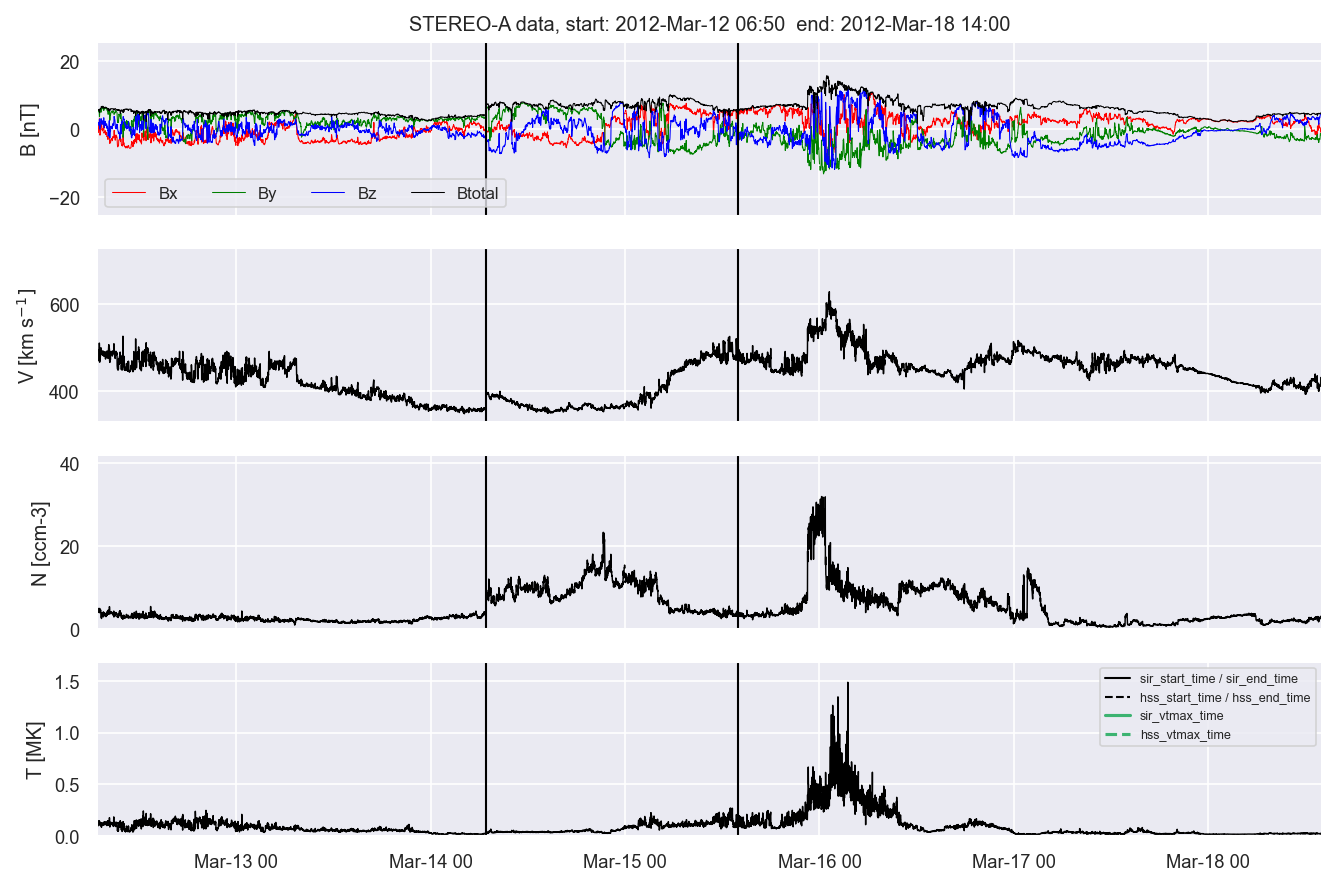

In [135]:
from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging

from heliocats import plot as hp
importlib.reload(hp) #reload again while debugging

#load master file
scat=hc.load_helio4cast_sircat_master_from_excel('sircat/HELIO4CAST_SIRCAT_v10_master.xlsx')
scat

####### 3a get indices for all spacecraft
wini=np.where(scat.sc_insitu == 'Wind')[:][0] 
pspi=np.where(scat.sc_insitu == 'PSP')[:][0] 
stai=np.where(scat.sc_insitu == 'STEREO-A')[:][0]    
stbi=np.where(scat.sc_insitu == 'STEREO-B')[:][0]    
mavi=np.where(scat.sc_insitu == 'MAVEN')[:][0]    

print('done')

####### 3b get parameters for all spacecraft one after another
# remove indices if the  events in the master file have changed
#os.system('rm sircat/indices_sircat/SIRCAT_indices_Wind.p')
#os.system('rm sircat/indices_sircat/SIRCAT_indices_STEREO-A.p')
#os.system('rm sircat/indices_sircat/SIRCAT_indices_STEREO-B.p')
#os.system('rm sircat/indices_sircat/SIRCAT_indices_MAVEN.p')
#os.system('rm sircat/indices_sircat/SIRCAT_indices_PSP.p')

#sir times
scat=hc.get_sircat_parameters(psp,pspi,scat,'PSP')
scat=hc.get_sircat_parameters(stb,stbi,scat,'STEREO-B')

#both allen and jian cats
#scat=hc.get_sircat_parameters(sta,stai,scat,'STEREO-A')


scat=hc.get_sircat_parameters(mav,mavi,scat,'MAVEN')



# ###### 3c make all plots if wanted
#matplotlib.use('Agg')
#hp.plot_sircat_events(psp,pspi,scat,'PSP',sirplotsdir)

#hp.plot_sircat_events(stb,stbi,scat,'STEREO-B',sirplotsdir)
#hp.plot_sircat_events(mav,mavi,scat,'MAVEN',sirplotsdir)


hp.plot_sircat_events(sta,stai,scat,'STEREO-A',sirplotsdir)
hp.plot_sircat_events(win,wini,scat,'Wind',sirplotsdir)

#hss times
#scat=hc.get_sircat_parameters(win,wini,scat,'Wind')
scat




#save as txt
file='sircat/HELIO4CAST_SIRCAT_v10.txt'
np.savetxt(file, scat.values.astype(str), fmt='%s' )
print('SIRCAT saved as '+file)




In [ ]:


#sir times
scat=hc.get_sircat_parameters(psp,pspi,scat,'PSP')
scat=hc.get_sircat_parameters(mav,mavi,scat,'MAVEN')


#both allen and jian cats
scat=hc.get_sircat_parameters(sta,stai,scat,'STEREO-A')


# ###### 3c make all plots if wanted
#matplotlib.use('Agg')
#hp.plot_sircat_events(sta,stai,scat,'STEREO-A',sirplotsdir)
#hp.plot_sircat_events(stb,stbi,scat,'STEREO-B',sirplotsdir)
#hp.plot_sircat_events(win,wini,scat,'Wind',sirplotsdir)
#hp.plot_sircat_events(mav,mavi,scat,'MAVEN',sirplotsdir)
#hp.plot_sircat_events(psp,pspi,scat,'PSP',sirplotsdir)


print('done')


#kick out MAVEN events without data


############### sort SIRCAt by date
scat = scat.sort_values(by='hss_start_time',ascending=False)
scat = scat.reset_index(drop=True)

### (4) save SIRCAT 

### 4a save header

In [8]:
#save header and parameters as text file and prepare for html website
header='SIR CATALOGUE v1.0 \n\n\
This is the HELIO4CAST stream interaction region (SIR) and high speed stream (HSS) catalog,\n\
based on in situ magnetic field and bulk plasma observations in the heliosphere. \n\
It is a merged catalog created from individual ones made by Robert Allen et al., Lan Jian et al., Maxim Grandin et al. and Hui Huang et al. (see references).\n\n\
This is version 1.0, released 2020-06-10, updated '+last_update+' doi: 10.6084/m9.figshare.12416906 \n\n\
The catalog is available as  python pandas dataframe (pickle), json, csv, xlsx, txt, html at \n\
https://helioforecast.space/sircat \n\n\
Number of events in SIRCAT: '+str(len(scat))+' \n\
ICME observatories: Parker Solar Probe, Wind, STEREO-A, STEREO-B, MAVEN   \n\
Time ranges: Parker Solar Probe: Oct 2018 - May 2020, Wind: Jan 2007 - Sep 2019, STEREO-A/B: Jan 2007 - Sep 2019, MAVEN: Dec 2014 - Jan 2018. \n\n\
Authors: Christian Moestl, Andreas J. Weiss, R. L. Bailey, Martin A. Reiss, GeoSphere Austria / NASA Goddard. \n\
Robert Allen, JHU/APL, USA; Lan Jian, NASA, USA; Maxim Grandin, University of Helsinki, Finland; Hui Huang, Beijing University, China. \n\n\
Rules: If results are produced with this catalog for peer-reviewed scientific publications, \n\
please contact chris.moestl@outlook.com, robert.allen@jhuapl.edu, lan.jian@nasa.gov, maxime.grandin@helsinki.fi for possible co-authorships. \n\n\
This catalog has been made by getting the start and end times of each high speed stream from the \n\
individual catalogs, and then calculating all parameters again consistently from the data by us. \n\
The in situ data that were used for the creating catalog, with a size of 8 GB in total, including extra data \n\
files with magnetic field components in RTN coordinates and other spacecrat that are not used for producing this catalog, \n\
can be downloaded in python pickle format as recarrays from https://doi.org/10.6084/m9.figshare.11973693.v7 \n\
The python code for producing this catalog is available at https://github.com/cmoestl/heliocats sircat.ipynb \n\n\
Each sircat_id has a tag in it that indicates from which catalog the ICME times were taken: \n\n\
Parker Solar Probe: Allen et al. 2021, tag: ALLEN, \n\
Wind:       Grandin et al. (2019), tag: GRANDIN \n\
STEREO-A:   Jian et al. (2019), tag: JIAN. \n\
STEREO-B:   Jian et al. (2019), tag: JIAN. \n\
MAVEN:      Huang et al. (2019), tag: HUANG. \n\n\
References \n\
Allen et al. (2021), https://doi.org/10.1051/0004-6361/202039833 \n\
Grandin, M. et al. (2019), https://doi.org/10.1029/2018JA026396 \n\
Jian, L. et al. (2019), https://doi.org/10.1007/s11207-019-1416-8 \n\
Huang, H. et al. (2019), https://doi.org/10.3847/1538-4357/ab25e9 \n\n\
Comments: \n\
- The STEREO catalog contains the SIR start, stream interface and SIR end times. We use their stream interface time as our hss_start_time. \n\
- The MAVEN catalog has similar times as the STEREO catalog.\n\
- Earth SIR/HSS list: This catalog directly gives the hss_start_time and the hss_end_time, but no SIR times.  \n\
- The times in the Earth SIR/HSS list have been modified to 1 hour earlier as these times were \n\
originally given for the magnetopause, but the Wind spacecraft is located at the L1 point. \n\
One hour is practically equivalent to the propagation time of a 400 km/s slow solar wind \n\
from the L1 point to the magnetopause.\n\
- Spacecraft positions are given in Heliocentric Earth Equatorial Coordinates (HEEQ) coordinates. \n\
- The coordinate system for all magnetic field components is SCEQ, except for Wind (HEEQ, which is the equivalent for SCEQ for Earth). \n\
        Definition of SpaceCraft Equatorial Coordinates (SCEQ): \n\
        Z is the solar rotation axis. \n\
        Y is the cross product of Z and R, with R being the vector that points from the Sun to the spacecraft.\n\
        X completes the right handed triad (and points away from the Sun). \n\
This system is thus like HEEQ but centered on the respective in situ spacecraft, so the SCEQ X and Y \n\
base vectors are rotated by the HEEQ longitude of the in situ spacecraft from HEEQ X and Y.\n\
The Y vector is similar to the T vector in an RTN system for each spacecraft, but the X and Z vectors \n\
are rotated around Y compared to an RTN system. The differences between RTN and SCEQ for spacecraft within \n\
a few degrees of the solar equatorial plane are very small (within a few 0.1 nT usually).\n\
We choose SCEQ because it has the advantage that a comparison between multipoint CME events \n\
and for comparison to simulations there is always a similar reference plane (the solar equatorial plane). \n\n '     


parameters_text='Parameters:\n\
00: sircat_id: The unique identifier for the observed stream interaction region (SIR). unit: string. \n\
01: sc insitu: The name of the in situ observing spacecraft. unit: string. \n\
02: sir_start_time: Stream interaction region start time. unit: UTC. \n\
03: hss_start_time: High speed stream start time, equal to the stream interface time (for STEREO, MAVEN catalogs). unit: UTC. \n\
04: sir_end_time: End time of the stream interaction region. unit: UTC. \n\
05: hss_end_time: High speed stream end time, criterion at Wind: speed < 450 km/s. unit: UTC. \n\
06: hss_vtmax_time: High speed stream maxmimum speed time. unit: UTC. \n\
07: sc_heliodistance: Heliocentric distance of the spacecraft at hss_start_time. unit: AU.\n\
08: sc_long_heeq: Heliospheric longitude of the spacecraft at hss_start_time, range [-180,180]. unit: degree (HEEQ).\n\
09: sc_lat_heeq: Heliospheric latitude of the spacecraft at hss_start_time, range [-90,90]. unit: degree (HEEQ).\n\
10: hss_vt_max: Maximum proton speed from hss_start_time to hss_end_time. unit: km/s.\n\
11: hss_vt_mean: Mean proton speed from hss_start_time to hss_end_time. unit: km/s.\n\
12: hss_vt_std: Standard deviation of proton speed from hss_start_time to hss_end_time. unit: km/s.\n\
13: hss_vt_mean: Mean proton speed from hss_start_time to hss_end_time. unit: km/s.\n\
14: hss_bt_max: Maximum total magnetic field from hss_start_time to hss_end_time. unit: nT.\n\
15: hss_bt_mean: Mean total magnetic field from hss_start_time to hss_end_time. unit: nT.\n\
16: hss_bt_std: Standard deviation of total magnetic field from hss_start_time to hss_end_time. unit: nT.\n\
17: hss_bz_min: Minimum Bz component (SCEQ) from hss_start_time to hss_end_time. unit: nT.\n\
18: hss_bz_mean: Mean Bz component (SCEQ) from hss_start_time to hss_end_time. unit: nT.\n\
19: hss_bz_std: Standard deviation of Bz component (SCEQ) from hss_start_time to hss_end_time. unit: nT.\n\
20: hss_duration: Duration of high speed stream from hss_start_time to hss_end_time. unit: hours.\n\
21: sir_vt_mean: Mean proton speed from hss_start_time to sir_end_time. unit: km/s.\n\
22: sir_vt_std: Standard deviation of proton speed from sir_start_time to hss_end_time. unit: km/s.\n\
23: sir_vt_mean: Mean proton speed from hss_start_time to sir_end_time. unit: km/s.\n\
24: sir_bt_max: Maximum total magnetic field from sir_start_time to hss_end_time. unit: nT.\n\
25: sir_bt_mean: Mean total magnetic field from sir_start_time to sir_end_time. unit: nT.\n\
26: sir_bt_std: Standard deviation of total magnetic field from sir_start_time to sir_end_time. unit: nT.\n\
27: sir_bz_min: Minimum Bz component (SCEQ) from sir_start_time to sir_end_time. unit: nT.\n\
28: sir_bz_mean: Mean Bz component (SCEQ) from sir_start_time to sir_end_time. unit: nT.\n\
29: sir_bz_std: Standard deviation of Bz component (SCEQ) from sir_start_time to sir_end_time. unit: nT.\n\
30: sir_duration: Duration of stream interaction region from sir_start_time to sir_end_time. unit: hours.\n\n\n'

print(header)
print(parameters_text)


#make header file
file='sircat/HELIO4CAST_SIRCAT_v10_header.txt'
with open(file, "w") as text_file:
    text_file.write(header)
    text_file.write(parameters_text)
print()    
print('header saved as '+file)
print()    

#Convert to html regarding line breaks, paragraph beginning and spaces
header_spaces=header.replace(" ", "&nbsp;")
header_html= "<p>" +header_spaces.replace('\n', '<br>')+ "</p>" 
parameters_spaces=parameters_text.replace(" ", "&nbsp;")
parameters_html= "<p>" +parameters_text.replace('\n', '<br>')+ "</p>"
print('header converted to HTML')
print()    
print()    

SIR CATALOGUE v1.0 

This is the HELIO4CAST stream interaction region (SIR) and high speed stream (HSS) catalog,
based on in situ magnetic field and bulk plasma observations in the heliosphere. 
It is a merged catalog created from individual ones made by Robert Allen et al., Lan Jian et al., Maxim Grandin et al. and Hui Huang et al. (see references).

This is version 1.0, released 2020-06-10, updated 2023-May-3 doi: 10.6084/m9.figshare.12416906 

The catalog is available as  python pandas dataframe (pickle), json, csv, xlsx, txt, html at 
https://helioforecast.space/sircat 

Number of events in SIRCAT: 1169 
ICME observatories: Parker Solar Probe, Wind, STEREO-A, STEREO-B, MAVEN   
Time ranges: Parker Solar Probe: Oct 2018 - May 2020, Wind: Jan 2007 - Sep 2019, STEREO-A/B: Jan 2007 - Sep 2019, MAVEN: Dec 2014 - Jan 2018. 

Authors: Christian Moestl, Andreas J. Weiss, R. L. Bailey, Martin A. Reiss, GeoSphere Austria / NASA Goddard. 
Robert Allen, JHU/APL, USA; Lan Jian, NASA, USA; Maxim

### 4b save into different formats

In [9]:
########## python formats

# save ICMECAT as pandas dataframe with times as datetime objects as pickle
file='sircat/HELIO4CAST_SIRCAT_v10_pandas.p'
pickle.dump([scat,header,parameters], open(file, 'wb'))
print('SIRCAT saved as '+file)


#load sircat as pandas dataframe
file='sircat/HELIO4CAST_SIRCAT_v10_pandas.p'
[scat_pandas,h,p]=pickle.load( open(file, 'rb'))   
scat.keys()
scat


####### get indices again for all spacecraft after sorting
wini=np.where(scat.sc_insitu == 'Wind')[:][0] 
pspi=np.where(scat.sc_insitu == 'PSP')[:][0] 
stai=np.where(scat.sc_insitu == 'STEREO-A')[:][0]    
stbi=np.where(scat.sc_insitu == 'STEREO-B')[:][0]    
mavi=np.where(scat.sc_insitu == 'MAVEN')[:][0]   


# # save SIRCAT as numpy array with times as matplotlib datetime as pickle
# scat_num=copy.deepcopy(scat) 
# scat_num.icme_start_time=parse_time(scat_num.icme_start_time).plot_date
# scat_num.mo_start_time=parse_time(scat_num.mo_start_time).plot_date
# scat_num.mo_end_time=parse_time(scat_num.mo_end_time).plot_date
# #convert to recarray
# scat_num_rec=scat_num.to_records()
# #create structured array
# dtype1=[('index','i8'),('icmecat_id', '<U30'),('sc_insitu', '<U20')] +[(i, '<f8') for i in ic.keys()[2:len(ic.keys())]]
# scat_num_struct=np.array(scat_num_rec,dtype=dtype1)



# file='icmecat/HELIO4CAST_ICMECAT_v20_numpy.p'
# pickle.dump([scat_num,scat_num_struct,header,parameters], open(file, 'wb'))
# print('ICMECAT saved as '+file)


################ save to different formats


#get beginning of tags for STA to identify allen and jian events
tag_list=[]
for i in np.arange(0,len(scat)):
    tag_list.append(scat.sircat_id[i][13]) #j

stai_jian=np.where(np.logical_and(scat.sc_insitu == 'STEREO-A',np.array(tag_list)=='J'))[:][0] 
stai_allen=np.where(np.logical_and(scat.sc_insitu == 'STEREO-A',np.array(tag_list)=='A'))[:][0] 

#get indices of all SIR spacecraft in SIRCAT
sir_sc=np.hstack([stai_jian,stbi,mavi])


#get indices of all HSS spacecraft in SIRCAT
hss_sc=np.hstack([pspi,wini,stai_allen])

#copy pandas dataframe first to change time format consistent with HELIO4CAST
scat_copy=copy.deepcopy(scat)

for i in sir_sc:  
    
    scat_copy.at[i,'sir_start_time']=parse_time(scat.sir_start_time[i]).isot[0:16]+'Z'
    scat_copy.at[i,'sir_end_time']=parse_time(scat.sir_end_time[i]).isot[0:16]+'Z'
    
for i in hss_sc:    
    scat_copy.at[i,'hss_start_time']=parse_time(scat.hss_start_time[i]).isot[0:16]+'Z'
    scat_copy.at[i,'hss_end_time']=parse_time(scat.hss_end_time[i]).isot[0:16]+'Z'
    #scat_copy.at[i,'hss_vtmax_time']=parse_time(scat.hss_vtmax_time[i]).isot[0:16]+'Z'
    
scat_copy


#save as Excel
file='sircat/HELIO4CAST_SIRCAT_v10.xlsx'
scat_copy.to_excel(file,sheet_name='SIRCATv1.0')
print('SIRCAT saved as '+file)

#save as json
file='sircat/HELIO4CAST_SIRCAT_v10.json'
scat_copy.to_json(file)
print('SIRCAT saved as '+file)

#save as csv
file='sircat/HELIO4CAST_SIRCAT_v10.csv'
scat_copy.to_csv(file)
print('SIRCAT saved as '+file)

#save as txt
file='sircat/HELIO4CAST_SIRCAT_v10.txt'
np.savetxt(file, scat_copy.values.astype(str), fmt='%s' )
print('SIRCAT saved as '+file)




#copy pandas dataframe first to change time format consistent with HELIO4CAST
scat_copy2=copy.deepcopy(scat)  

for i in sir_sc:  
    
    scat_copy2.at[i,'sir_start_time']=parse_time(scat.sir_start_time[i]).iso[0:16]+'Z'
    scat_copy2.at[i,'sir_end_time']=parse_time(scat.sir_end_time[i]).iso[0:16]+'Z'
    
for i in hss_sc:    
    scat_copy2.at[i,'hss_start_time']=parse_time(scat.hss_start_time[i]).iso[0:16]+'Z'
    scat_copy2.at[i,'hss_end_time']=parse_time(scat.hss_end_time[i]).iso[0:16]+'Z'
    #scat_copy.at[i,'hss_vtmax_time']=parse_time(scat.hss_vtmax_time[i]).isot[0:16]+'Z'


#save as json for webpage with different time format
file='sircat/HELIO4CAST_SIRCAT_v10_isot.json'
scat_copy2.to_json(file)
print('SIRCAT saved as '+file)


#save as html no header
file='sircat/HELIO4CAST_SIRCAT_v10_simple.html'
scat_copy.to_html(file)
print('SIRCAT saved as '+file)


############ save as html file with header
#save as html
file='sircat/HELIO4CAST_SIRCAT_v10.html'
#ic.to_html(file,justify='center')

#ichtml='{% extends "_base.html" %} \n \n {% block content %} \n \n \n '
ichtml = header_html
ichtml += parameters_html
ichtml += scat_copy.to_html()
#ichtml +='\n \n {% endblock %}'


with open(file,'w') as f:
    f.write(ichtml)
    f.close()
    
print('SIRCAT saved as '+file)    


SIRCAT saved as sircat/HELIO4CAST_SIRCAT_v10_pandas.p
SIRCAT saved as sircat/HELIO4CAST_SIRCAT_v10.xlsx
SIRCAT saved as sircat/HELIO4CAST_SIRCAT_v10.json
SIRCAT saved as sircat/HELIO4CAST_SIRCAT_v10.csv
SIRCAT saved as sircat/HELIO4CAST_SIRCAT_v10.txt
SIRCAT saved as sircat/HELIO4CAST_SIRCAT_v10_isot.json
SIRCAT saved as sircat/HELIO4CAST_SIRCAT_v10_simple.html
SIRCAT saved as sircat/HELIO4CAST_SIRCAT_v10.html


## 4c load ICMECAT pickle files

In [10]:

#load sircat as pandas dataframe
file='sircat/HELIO4CAST_SIRCAT_v10_pandas.p'
[scat_pandas,h,p]=pickle.load( open(file, 'rb'))   
scat.keys()
scat

#load icmecat as numpy array
# file='icmecat/HELIO4CAST_ICMECAT_v20_numpy.p'
# [ic_nprec,ic_np,h,p]=pickle.load( open(file, 'rb'))   


,sircat_id,sc_insitu,sir_start_time,hss_start_time,sir_end_time,hss_end_time,hss_vtmax_time,sc_heliodistance,sc_long_heeq,sc_lat_heeq,...,sir_vtmax,sir_vtmean,sir_vtstd,sir_btmax,sir_btmean,sir_btstd,sir_bzmin,sir_bzmean,sir_bzstd,sir_duration
0,SIR_PSP_ALLEN_20211114_01,PSP,NaN,2021-11-14 01:30:00,NaN,2021-11-14 09:40:00,NaN,0.3152,-44.68,3.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SIR_PSP_ALLEN_20210907_01,PSP,NaN,2021-09-07 01:30:00,NaN,2021-09-08 09:30:00,NaN,0.6727,-36.76,3.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SIR_PSP_ALLEN_20210821_01,PSP,NaN,2021-08-21 22:00:00,NaN,2021-08-22 15:30:00,NaN,0.4281,-40.27,2.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SIR_PSP_ALLEN_20210806_01,PSP,NaN,2021-08-06 02:20:00,NaN,2021-08-06 06:30:00,NaN,0.1936,78.21,2.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SIR_PSP_ALLEN_20210618_01,PSP,NaN,2021-06-18 01:30:00,NaN,2021-06-18 19:00:00,2021-06-18 15:09:00,0.7821,55.07,3.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164,SIR_WIND_GRANDIN_20070225_01,Wind,NaN,2007-02-25 00:00:00,NaN,2007-03-02 14:00:00,NaN,0.9809,0.05,-7.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1165,SIR_WIND_GRANDIN_20070212_01,Wind,NaN,2007-02-12 08:00:00,NaN,2007-02-18 01:00:00,NaN,0.9772,0.17,-5.74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1166,SIR_WIND_GRANDIN_20070128_01,Wind,NaN,2007-01-28 00:00:00,NaN,2007-02-02 23:00:00,NaN,0.9772,0.17,-5.74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1167,SIR_WIND_GRANDIN_20070114_01,Wind,NaN,2007-01-14 08:00:00,NaN,2007-01-22 04:00:00,NaN,0.9771,0.19,-4.81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
scat_pandas
scat_pandas.keys()

Index(['sircat_id', 'sc_insitu', 'sir_start_time', 'hss_start_time',
       'sir_end_time', 'hss_end_time', 'hss_vtmax_time', 'sc_heliodistance',
       'sc_long_heeq', 'sc_lat_heeq', 'hss_vtmax', 'hss_vtmean', 'hss_vtstd',
       'hss_btmax', 'hss_btmean', 'hss_btstd', 'hss_bzmin', 'hss_bzmean',
       'hss_bzstd', 'hss_duration', 'sir_vtmax', 'sir_vtmean', 'sir_vtstd',
       'sir_btmax', 'sir_btmean', 'sir_btstd', 'sir_bzmin', 'sir_bzmean',
       'sir_bzstd', 'sir_duration'],
      dtype='object')

Text(0.5, 0, 'Duration [hours]')

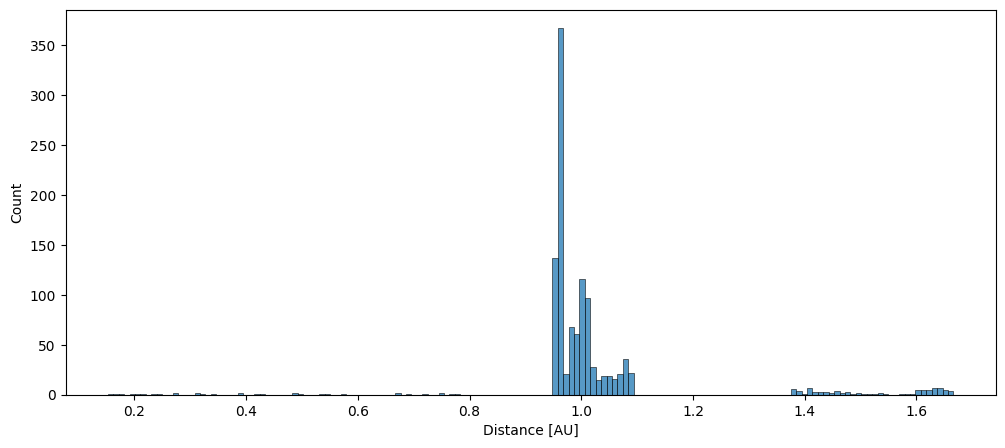

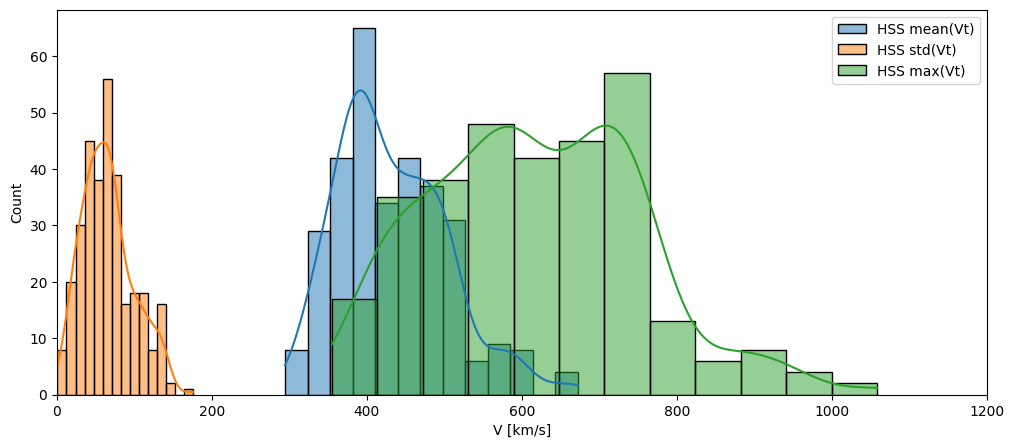

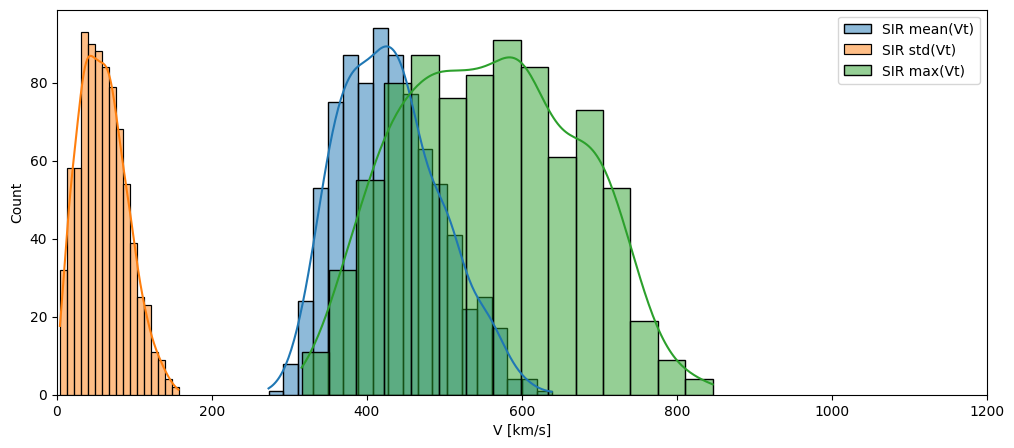

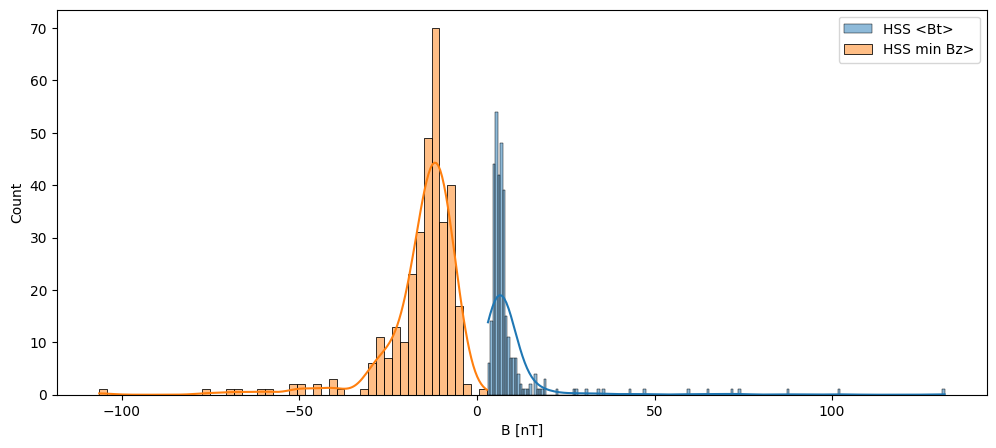

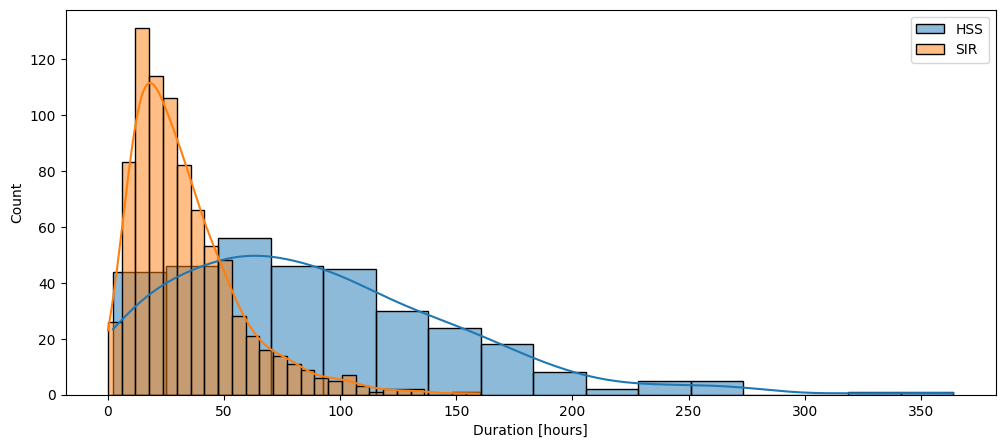

In [12]:
#make distribution plots
plt.figure(20,figsize=(12,5), dpi=100)
sns.histplot(scat.sc_heliodistance)
plt.xlabel('Distance [AU]')

plt.figure(21,figsize=(12,5), dpi=100)
sns.histplot(scat.hss_vtmean,kde=True, label='HSS mean(Vt)')
sns.histplot(scat.hss_vtstd, kde=True, label='HSS std(Vt)')
sns.histplot(scat.hss_vtmax, kde=True, label='HSS max(Vt)')
plt.legend()
plt.xlabel('V [km/s]')
plt.xlim(0,1200)



plt.figure(22,figsize=(12,5), dpi=100)
sns.histplot(scat.sir_vtmean,kde=True, label='SIR mean(Vt)')
sns.histplot(scat.sir_vtstd, kde=True, label='SIR std(Vt)')
sns.histplot(scat.sir_vtmax, kde=True, label='SIR max(Vt)')
plt.legend()
plt.xlim(0,1200)
plt.xlabel('V [km/s]')


plt.figure(23,figsize=(12,5), dpi=100)
sns.histplot(scat.hss_btmean,kde=True, label='HSS <Bt>')
sns.histplot(scat.hss_bzmin,kde=True, label='HSS min Bz>')
plt.legend()
plt.xlabel('B [nT]')

plt.figure(24,figsize=(12,5), dpi=100)
sns.histplot(scat.hss_duration, kde=True, label='HSS')
sns.histplot(scat.sir_duration, kde=True, label='SIR')
plt.legend()
plt.xlabel('Duration [hours]')